# Notebook to generate the 3DMNIST dataset

In [1]:
import gzip
import h5py
import pickle
import os
import numpy as np

try:
    from tqdm import trange
except ImportError:
    trange = range
    
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['image.interpolation'] = None
plt.rcParams['image.cmap'] = 'gray'

## Load de original mnist dataset

In [2]:
f = gzip.open('data/mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = pickle.load(f, encoding="iso-8859-1")
f.close()

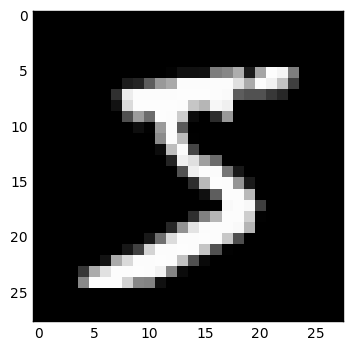

In [3]:
plt.imshow(train_set[0][0].reshape(28,28))

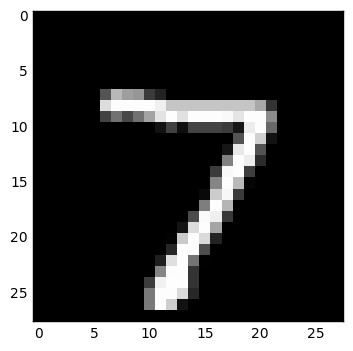

In [4]:
plt.imshow(test_set[0][0].reshape(28,28))

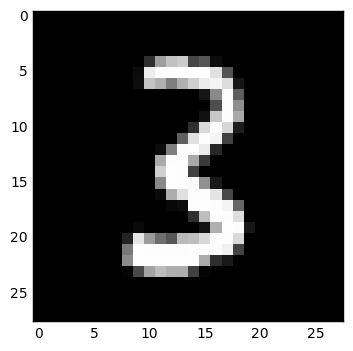

In [5]:
plt.imshow(valid_set[0][0].reshape(28,28))

## Function to convert image into 3D point cloud

This function will:
- Find the pixels coords whith non zero values.
- Build a 3D point cloud representing the voxels associated to each non zero pixel coords.

In [6]:
def img_to_point_cloud(input_image, voxel):

    non_zero_coord = np.transpose(np.nonzero(input_image))
    
    # dict for fast looking of neighboor ocupancy
    non_zero_dict = {}
    for i in range(input_image.shape[0]):
        for j in range(input_image.shape[1]):
            non_zero_dict[str([i,j])] = any(np.all([i,j] == non_zero_coord, axis=1))

    cloud = []
    
    for n in range(len(non_zero_coord)):
        x = non_zero_coord[n][0]
        y = non_zero_coord[n][1]
            
        components = [0,1]
        
        # top
        if not non_zero_dict[str([x-1, y])]:
            components.append(2)
        
        # bottom
        if not non_zero_dict[str([x+1, y])]:
            components.append(3)
        
        # left
        if not non_zero_dict[str([x, y-1])]:
            components.append(4)
        
        # right
        if not non_zero_dict[str([x, y+1])]:
            components.append(5)
        
        pixel_cloud = np.concatenate(voxel[components])
                
        # move the voxel to its position
        pixel_cloud[:,0] +=x
        pixel_cloud[:,1] += y
        
        cloud.append(pixel_cloud)
    
    cloud = np.concatenate(cloud)
    
    # make max range 0-1
    xyzmin = np.min(cloud[:,:3], axis=0)
    xyzmax = np.max(cloud[:,:3], axis=0)
    diff = xyzmax - xyzmin
    cloud[:,:3] = ((cloud[:,:3] - xyzmin[np.argmax(diff)]) / diff[np.argmax(diff)])
    
    # 0 mean
    cloud[:,:3] -= np.mean(cloud[:,:3], axis=0)

    return cloud

## Define voxel parameters

In [7]:
MIN_X, MAX_X = (-0.5, 0.5)
MIN_Y, MAX_Y = (-0.5, 0.5)
MIN_Z, MAX_Z = (-3, 3)

N_X = 5
N_Y = 5
N_Z = 30

In [8]:
# VOXEL CREATION
# with normals

front = np.array(np.meshgrid(np.linspace(MIN_X, MAX_X, N_X),
                             np.linspace(MIN_Y, MAX_Y, N_Y),
                             MAX_Z )).T.reshape(-1,3) 
front = np.concatenate((front, [[1,0,0]] * len(front)), axis=1)


back = np.array(np.meshgrid(np.linspace(MIN_X, MAX_X, N_X), 
                            np.linspace(MIN_Y, MAX_Y, N_Y), 
                            MIN_Z )).T.reshape(-1,3)    
back = np.concatenate((back, [[-1,0,0]] * len(back)), axis=1)


top = np.array(np.meshgrid(MIN_X,
                           np.linspace(MIN_Y, MAX_Y, N_Y), 
                           np.linspace(MIN_Z, MAX_Z, N_Z))).T.reshape(-1,3)
top = np.concatenate((top, [[0,0,1]] * len(top)), axis=1)


bottom = np.array(np.meshgrid(MAX_X, 
                              np.linspace(MIN_Y, MAX_Y, N_Y), 
                              np.linspace(MIN_Z, MAX_Z, N_Z))).T.reshape(-1,3) 
bottom = np.concatenate((bottom, [[0,0,-1]] * len(bottom)), axis=1)


left = np.array(np.meshgrid(np.linspace(MIN_X, MAX_X, N_X), 
                            MIN_Y,
                            np.linspace(MIN_Z, MAX_Z, N_Z))).T.reshape(-1,3)
left = np.concatenate((left, [[0,-1,0]] * len(left)), axis=1)


right = np.array(np.meshgrid(np.linspace(MIN_X, MAX_X, N_X), 
                             MAX_Y, 
                             np.linspace(MIN_Z, MAX_Z, N_Z))).T.reshape(-1,3)   
right = np.concatenate((right, [[0,1,0]] * len(right)), axis=1)


voxel = np.array([front, back, top, bottom, left, right])

## Function to rotate along y axis

In [9]:
def Ry(angle, degrees=True):

    if degrees:
        
        cy = np.cos(np.deg2rad(angle))
        sy = np.sin(np.deg2rad(angle))
        
    else:
        
        cy = np.cos(angle)
        sy = np.sin(angle)
        
    Ry = np.array(
    [[cy , 0  , -sy, 0  ],
     [0  , 1  , 0  , 0  ],
     [sy , 0  , cy , 0  ],
     [0  , 0  , 0  , 1  ]])
    
    return Ry

## Function to save dataset to HDF5

In [10]:
def save_dataset(X, y, voxel, output, shape=(28,28)):
    
    img = np.zeros((shape[0] + 2, shape[1] + 2))
    
    with h5py.File(output, "w") as hf:
        
        for i in trange(len(X)):
            
            img[1:-1,1:-1] = X[i].reshape(shape[0], shape[1])
            data = img_to_point_cloud(img, voxel)
            
            # rotate to vertical
            transf = np.c_[ data[:,:3], np.ones(data[:,:3].shape[0]) ]
            transf = transf @ Ry(90)
            data[:,:3] = transf[:,:-1]
            
            grp = hf.create_group(str(i))
            grp.create_dataset("img", data=img, compression="gzip")
            grp.create_dataset("points", data=data[:,:3], compression="gzip")
            grp.create_dataset("normals", data=data[:,3:], compression="gzip",)
            grp.attrs["label"] = y[i]
            

## Define output directories

In [11]:
OUTPUT_TRAIN = "D:/train.h5"
N_TRAIN = 5000
OUTPUT_TEST = "D:/test.h5"
N_TEST = 1000
OUTPUT_VALID = "D:/valid.h5"
N_VALID = 1000

In [12]:
if os.path.exists(OUTPUT_TRAIN):
    print (OUTPUT_TRAIN, "Already exists")
else:
    save_dataset(train_set[0][:N_TRAIN], train_set[1][:N_TRAIN], voxel, OUTPUT_TRAIN)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:45<00:00, 22.13it/s]


In [13]:
if os.path.exists(OUTPUT_TEST):
    print (OUTPUT_TEST, "Already exists")
else:
    save_dataset(test_set[0][:N_TEST], test_set[1][:N_TEST], voxel, OUTPUT_TEST)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:44<00:00, 21.87it/s]


In [14]:
if os.path.exists(OUTPUT_VALID):
    print (OUTPUT_VALID, "Already exists")
else:
    save_dataset(valid_set[0][:N_VALID], valid_set[1][:N_VALID], voxel, OUTPUT_VALID)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.00it/s]
